# SPRINT 1 FINANCER

### En quina mesura els clients amb saldos més baixos estan en més risc d'incompliment de crèdit, i com hem d'ajustar les nostres polítiques de crèdit permitigar aquest risc?


## 1. IMPORTACIÓ BD I CREACIÓ DE DF

In [1]:
from sqlalchemy import create_engine, inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, time, datetime
%pip install pymysql
import pymysql
#Dades de connexió

usuario='EquipoB'
contraseña="E1q2u3i4p5oB"
host='212.227.90.6'
puerto=3306
nombre_base_datos='EquipB'

#URL de la connexió
url_conexion=f"mysql+pymysql://{usuario}:{contraseña}@{host}:{puerto}/{nombre_base_datos}"

#Crear l'engine de SQLAlchemy
try:
    engine=create_engine(url_conexion)
    cnx=engine.connect()
    print("conexió correcta")
except Exception as e:
    print(f"Error al conectar con SQLAlchemy: {e}")
    
#Obtenir nom de les taules
inspector=inspect(engine)
nombre_tablas=inspector.get_table_names()

#M'asseguro que la vista_finances també tingui el seu DF
if 'vista_finances' not in nombre_tablas:
    nombre_tablas.append('vista_finances')
#Emmagatzemar el DataFrames en una llista
df= {}

for taula in nombre_tablas:
    query=f"select * from {taula}"
    
    try:
        df[taula] = pd.read_sql(query, cnx)
        print(f"Taula '{taula}' carregada correctament.")
    except Exception as e:
        print(f"Error al carregar la taula '{taula}':{e}")

#cnx.close()


conexió correcta
Taula 'BANK_marketing' carregada correctament.
Taula 'vista_finances' carregada correctament.


In [2]:
print(nombre_tablas)

['BANK_marketing', 'vista_finances']


## 2. EDA: ANÀLISI EXPLORATÒRI
Examinem les variables faltante i balance

In [3]:
df_bank = df['BANK_marketing']
df_vistaf = df['vista_finances']
df_vistaf.head()


,id,age,job,marital,education,faltante,balance,housing,loan
0,1,59,admin.,married,secondary,0,2343,1,0
1,3,56,admin.,married,secondary,0,45,0,0
2,4,41,technician,married,secondary,0,1270,1,0
3,5,55,services,married,secondary,0,2476,1,0
4,6,54,admin.,married,tertiary,0,184,0,0


In [4]:
len(df_vistaf)

11162

In [5]:
df_vistaf.describe()

,id,age,faltante,balance,housing,loan
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,5582.499910,41.232754,0.015051,1528.538524,0.473123,0.130801
std,3222.336342,11.910672,0.121761,3225.413326,0.499299,0.337198
min,1.000000,18.000000,0.000000,-6847.000000,0.000000,0.000000
25%,2792.250000,32.000000,0.000000,122.000000,0.000000,0.000000
50%,5582.500000,39.000000,0.000000,550.000000,0.000000,0.000000
75%,8372.750000,49.000000,0.000000,1708.000000,1.000000,0.000000
max,11163.000000,95.000000,1.000000,81204.000000,1.000000,1.000000


In [6]:
df_vistaf['faltante'].value_counts()

faltante
0    10994
1      168
Name: count, dtype: int64

In [7]:
df_vistaf['balance'].value_counts()

balance
 0       774
 1        39
 3        35
 2        34
 4        29
        ... 
 5517      1
 8332      1
 4859      1
-267       1
-134       1
Name: count, Length: 3805, dtype: int64

In [8]:
df_vistaf['balance'].isnull().sum()

0

Busquem posibles outliers a balance.

In [9]:
Q1 = df_vistaf['balance'].quantile(0.25)
Q3 = df_vistaf['balance'].quantile(0.75)
IQR = Q3 - Q1

outliers = (df_vistaf['balance'] < (Q1-1.5*IQR)) | (df_vistaf['balance'] > (Q3 + 1.5*IQR))
outliers.sum()



1055

In [10]:
(1055/11162)*100

9.451711162874037

Representa un 9.45% de la mostra, son molts, vegem la distribució amb visualitzacions primer i després ens plantejarem com afrontar el problema.

### VISUALITZACIONS

#### FALTANTE

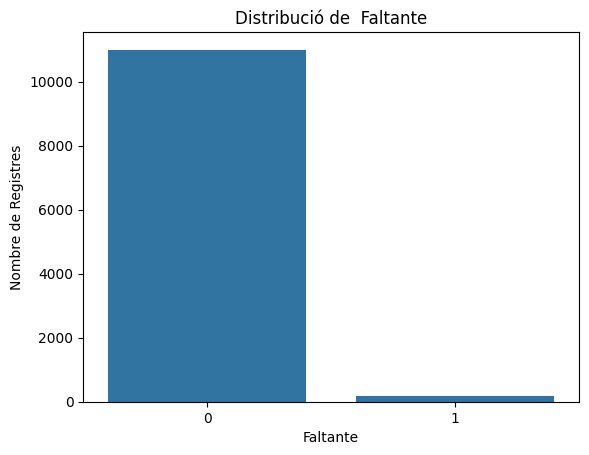

In [11]:
sns.countplot(x='faltante', data= df_vistaf)
plt.title('Distribució de  Faltante')
plt.xlabel('Faltante')
plt.ylabel('Nombre de Registres')
plt.show()

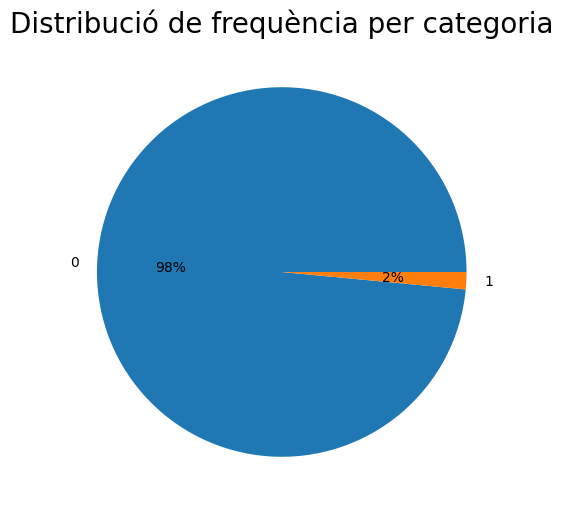

In [12]:
compteig_faltante= df_vistaf['faltante'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(compteig_faltante,labels=compteig_faltante.index, autopct='%1.0f%%')
plt.title("Distribució de frequència per categoria", fontsize=20 )
plt.show()

Podem veure que es una distribució molt asimètrica hi ha només un 2% de clients amb 'faltante' al banc. Es a dir el 98% dels clients no están en situació de morositat amb el banc.

#### BALANCE

<function matplotlib.pyplot.show(close=None, block=None)>

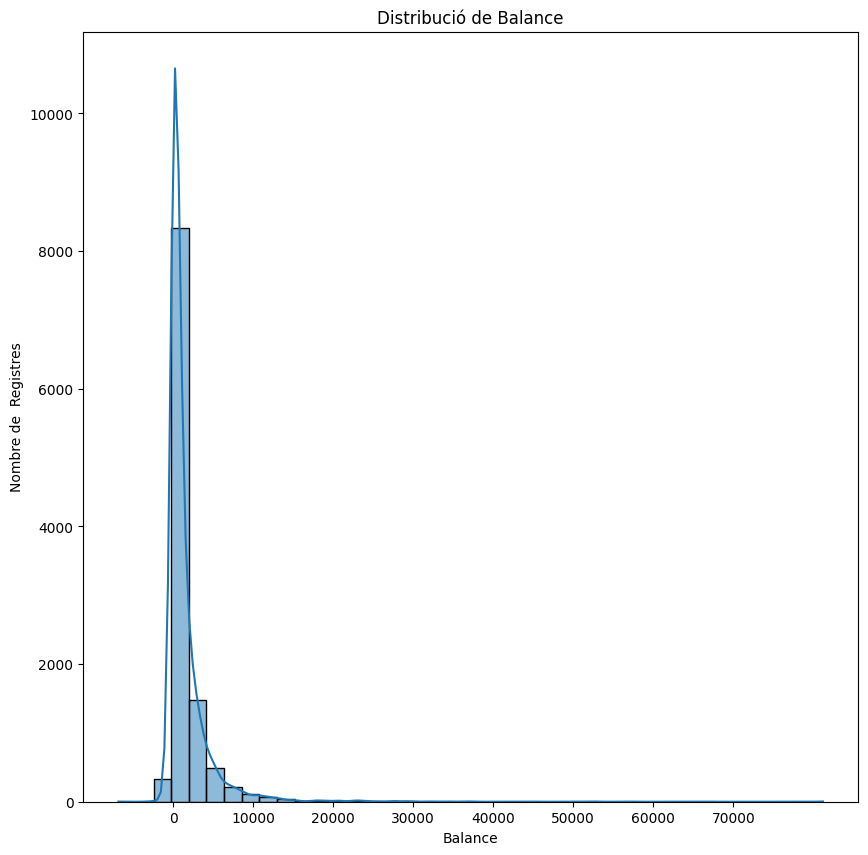

In [13]:
plt.figure(figsize=(10,10))
sns.histplot(df_vistaf['balance'], bins=40, kde=True)
plt.title('Distribució de Balance')
plt.xlabel('Balance')
plt.ylabel('Nombre de  Registres')
plt.xticks(range(0,80000,10000))
plt.show

Podem veure una distribució asimètrica amb cua a la dreta. Hi ha un pic molt destacat entre 0 i el proper bin on hi ha la inmensa majoria de registres. La majoria de clientes tenen balanços entre 0 i 2000,  mentre que molt pocs clients tenen blanços molt alts, de mes 50.000.

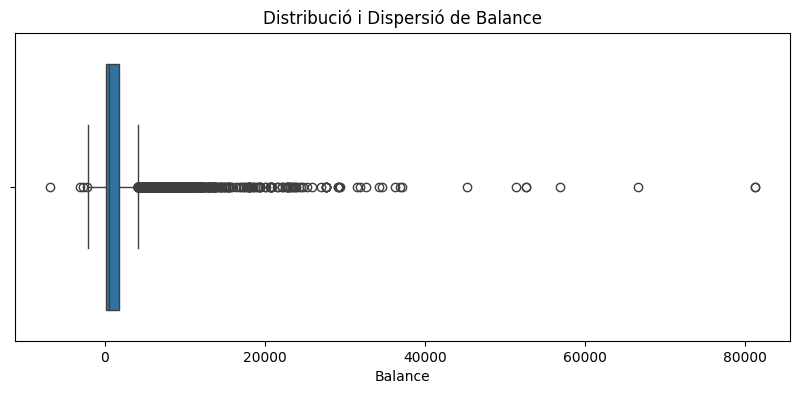

In [14]:
plt.figure(figsize=(10,4))
sns.boxplot(x=df_vistaf['balance'])
plt.title('Distribució i Dispersió de Balance')
plt.xlabel('Balance')
plt.show()

Podem veure una caixa entre Q1 i Q3 molt estreta i, per tant una gran concentració de clients amb 'balance' entre 0 i 2000.
Veiem el gran nombre d'outliers que apareixen , sobretot per la dreta, confirmant el que mostrava el primer anàlisis numéric d'outliers.
Semblaria que la immensa majoria de clients utilitzen el banc com banc de gestió de nòmines i pagaments corrents i una petita part l'utlitza també coma  banc d'inversió i d'estalvi.
També es pot valorar la possibilitat que, aquesta distribució de 'balance', representi la distribució de la riquesa en la societat d'aquell país i que, per tant, poguem inferir que es tracta d'un país on la inmensa majoria de la gent no te estalvis, mentre que un minoria sí que en té.

## 3. ANÁLISIS COMPARATIVO BALANCE Vs DEFAULT

Ponemos en común nuestros análisis exploratorios y hablamos de los outliers. Finalmente decidimos
seguir la estrategia que propone Natalya para realizar el análisis comparativo de las dos variables:
categorizar la variable balance para ver como varia el porcentaje de incumplimiento de crédito en cada
categoría.

Ante el problema de los numerosos outliers de balance , en parte mitigado por la categorización de la
variable, decidimos seguir en paralelo el análisis comparativo de las dos variables, uno lo realiza sin
alterar la variable "balance" y otro tratando el problema de los outliers , así después podremos poner en común los resultados y sacar conclusiones.

Aplico el cambio de nombre de la variable "faltante" así como el de sus valores a si i no para hacer más claras las visualizaciones. De ser necesario, más adelante, se podrian transformar a booleanos.

In [15]:
df_vistaf['faltante']= df_vistaf['faltante'].replace({0:"no", 1:"si"})

df_vistaf = df_vistaf.rename(columns = {'faltante':'incumplimiento_crédito'})

### DISTRIBUCIÓN DE BALANCE CON INCUMPLIMIENTO Y SIN

Antes de profundizar en el análisis comparativo, realizo unas visualizaciones para comparar la distribución de balance de los clientes que estan en incumplimiento y los que no.

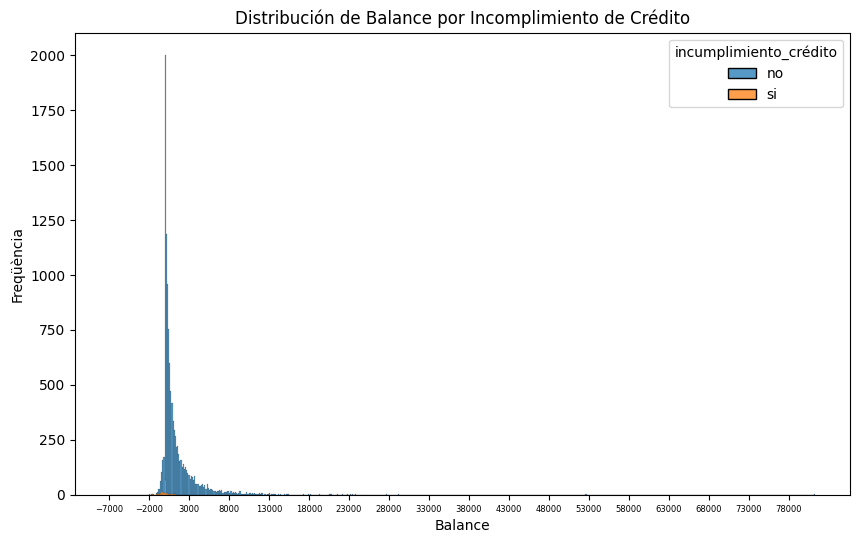

In [16]:
plt.figure(figsize=(10, 6))

sns.histplot(data=df_vistaf, x='balance', hue='incumplimiento_crédito', multiple='stack')

plt.title('Distribución de Balance por Incomplimiento de Crédito')
plt.xlabel('Balance')
plt.ylabel('Freqüència')
plt.xticks(range(-7000,82000,5000), fontsize=6)
plt.show()

Para poder comparar mejor salvamos la gran diferencia de registros creando un gràfico de densidad.

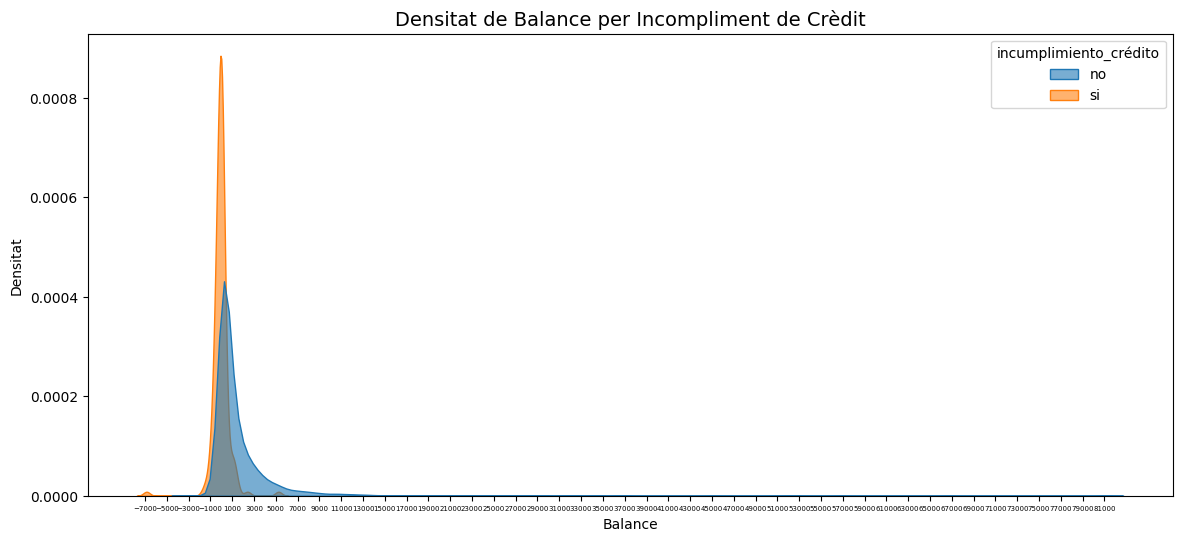

In [17]:
plt.figure(figsize=(14, 6))

sns.kdeplot(data=df_vistaf, x='balance', hue='incumplimiento_crédito', fill=True, common_norm=False, alpha=0.6)

plt.title('Densitat de Balance per Incompliment de Crèdit', fontsize=14)
plt.xlabel('Balance')
plt.ylabel('Densitat')

plt.xticks(range(-7000,82000,2000), fontsize=5)

plt.show()

### OUTLIERS
Viendo la distribución de "balance" y la gran cantidad de outliers (9,45%) se nos presentan varias opciones para su tratamiento: 
* Dejarlos: Eso es lo que hará Natalya para luego ponerlo en común.
* Eliminarlos: Aplicando la formula +- 1.5 * IQR.
* Truncar los valores en un tope determinado
* Estandarizar
* Aplicar una transformación logarítmica


Analizamos la composición de los outliers con más detenimiento.

                 id          age       balance      housing         loan
count   1055.000000  1055.000000   1055.000000  1055.000000  1055.000000
mean    5140.026540    44.426540   8413.330806     0.399052     0.063507
std     3183.738561    13.070966   6943.962727     0.489936     0.243988
min       11.000000    20.000000  -6847.000000     0.000000     0.000000
25%     2520.500000    34.000000   4929.500000     0.000000     0.000000
50%     4698.000000    42.000000   6281.000000     0.000000     0.000000
75%     7907.500000    53.000000   9203.000000     1.000000     0.000000
max    11103.000000    87.000000  81204.000000     1.000000     1.000000
<class 'pandas.core.frame.DataFrame'>
Index: 1055 entries, 9 to 11101
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      1055 non-null   int64 
 1   age                     1055 non-null   int64 
 2   job                     1055

([<matplotlib.axis.XTick at 0x21e5f01b850>,
 [Text(-7000, 0, '−7000'),
  Text(-5000, 0, '−5000'),
  Text(-3000, 0, '−3000'),
  Text(-1000, 0, '−1000'),
  Text(1000, 0, '1000'),
  Text(3000, 0, '3000'),
  Text(5000, 0, '5000'),
  Text(7000, 0, '7000'),
  Text(9000, 0, '9000'),
  Text(11000, 0, '11000'),
  Text(13000, 0, '13000'),
  Text(15000, 0, '15000'),
  Text(17000, 0, '17000'),
  Text(19000, 0, '19000'),
  Text(21000, 0, '21000'),
  Text(23000, 0, '23000'),
  Text(25000, 0, '25000'),
  Text(27000, 0, '27000'),
  Text(29000, 0, '29000'),
  Text(31000, 0, '31000'),
  Text(33000, 0, '33000'),
  Text(35000, 0, '35000'),
  Text(37000, 0, '37000'),
  Text(39000, 0, '39000'),
  Text(41000, 0, '41000'),
  Text(43000, 0, '43000'),
  Text(45000, 0, '45000'),
  Text(47000, 0, '47000'),
  Text(49000, 0, '49000'),
  Text(51000, 0, '51000'),
  Text(53000, 0, '53000'),
  Text(55000, 0, '55000'),
  Text(57000, 0, '57000'),
  Text(59000, 0, '59000'),
  Text(61000, 0, '61000'),
  Text(63000, 0, '630

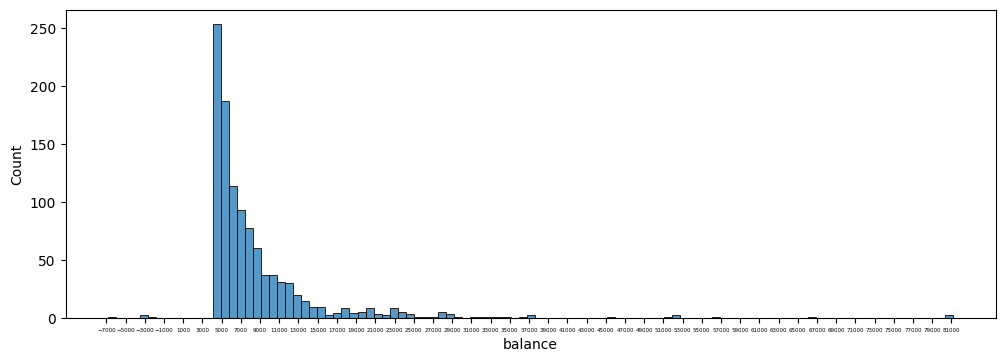

In [18]:
df_outliers = df_vistaf[outliers]

print(df_outliers.describe())
print(df_outliers.info())

plt.figure(figsize=(12,4))
sns.histplot(df_outliers['balance'])
plt.xticks(range(-7000,82000,2000),fontsize = 4)

Viendo la distribuición tan asimétrica de los outliers, totalmente decantada hacia los valores más altos, decido que el mejor método para tratar los outliers será aplicar una transformación logarítmica, ya que es el mejor método para valores muy altos en distribuciones con mucha dispersión.

Además considero que los otros métodos no serían del todo adequados:

Eliminarlos sería desvirtuar la muestra y alterar totalmente los datos reales. 
Para truncarlos necesitaria aplicar un valor de límite y necessitaria un mayor conocimiento de la muestra y del mundo financiero. Además también estaría alterando la muestra.
La estandarización sería una solución más neutra y no altera los datos però, en realidad, tampoco resuelve el problema de la "deformación" de la muestra por culpa de los numerosos y muy extremos outliers.

La transformación logaritmica sí corrige la "deformación" de la muestra por los outliers, pero tambien varia en cierta medida la relación entre los valores, cosa que considero un mal menor.
El único impedimento para realizarlo es que no se puede aplicar con valores negativos así que opto por la solucion más fácil i más inocua: Sumar una constante del valor mínimo + 1 a todos los valores y después aplicar la transformacion logarítmica con el logarimo natural de cada valor resultante:

log(x+(min+1))

In [19]:
min_balance = df_vistaf['balance'].min()
df_vistaf['balance_log'] = np.log(df_vistaf['balance'] + abs(min_balance) + 1)
df_vistaf[['balance', 'balance_log']].head()

,balance,balance_log
0,2343,9.125980
1,45,8.838262
2,1270,9.001839
3,2476,9.140347
4,184,8.858226


#### CATEGORIZACION
Primero definimos los cuartiles.

In [45]:
def cuartiles(df):
    #calcular cuartiles
    Q1 = df.quantile(0.25)
    Q2 = df.quantile(0.50)
    Q3 = df.quantile(0.75)

    #calcular IQR (rango intercuartílico)
    IQR = Q3 - Q1

    #calcular límite outliers
    min_Q = Q1 - 1.5*IQR
    max_Q = Q3 + 1.5*IQR
    
    return Q1, Q2, Q3, min_Q, max_Q

Q1, Q2, Q3, min_Q, max_Q = cuartiles(df_vistaf['balance_log'])

Asignamos las categorias según los cuartiles creados.

In [46]:
def clasificacion_clientes (balance):
    if balance < min_Q:
        return 'muy bajo'
    elif balance < Q1:
        return 'bajo'
    elif balance < Q2:
        return 'medio-bajo'
    elif balance < Q3:
        return 'medio-alto'
    elif balance < max_Q:
        return 'alto'
    else:
        return 'muy alto'
    
df_vistaf['descripcion_balance_log'] = df_vistaf['balance_log'].apply(clasificacion_clientes)

df_vistaf.head()

,id,age,job,marital,education,incumplimiento_crédito,balance,housing,loan,balance_log,descripcion_balance,incumplimiento_crédito_num,balance_bins,descripcion_balance_log
0,1,59,admin.,married,secondary,no,2343,1,0,9.125980,alto,0,"(9.109, 10.247]",alto
1,3,56,admin.,married,secondary,no,45,0,0,8.838262,bajo,0,"(7.97, 9.109]",bajo
2,4,41,technician,married,secondary,no,1270,1,0,9.001839,medio-alto,0,"(7.97, 9.109]",medio-alto
3,5,55,services,married,secondary,no,2476,1,0,9.140347,alto,0,"(9.109, 10.247]",alto
4,6,54,admin.,married,tertiary,no,184,0,0,8.858226,medio-bajo,0,"(7.97, 9.109]",medio-bajo


In [47]:
df_vistaf['balance_log'].min()
df_vistaf['balance_log'].max()

11.385682828033222

Ahora comparamos las dos variables categoricas, creando la media de incumpliento por cada categoria de balance para visualizarlo.

<function matplotlib.pyplot.show(close=None, block=None)>

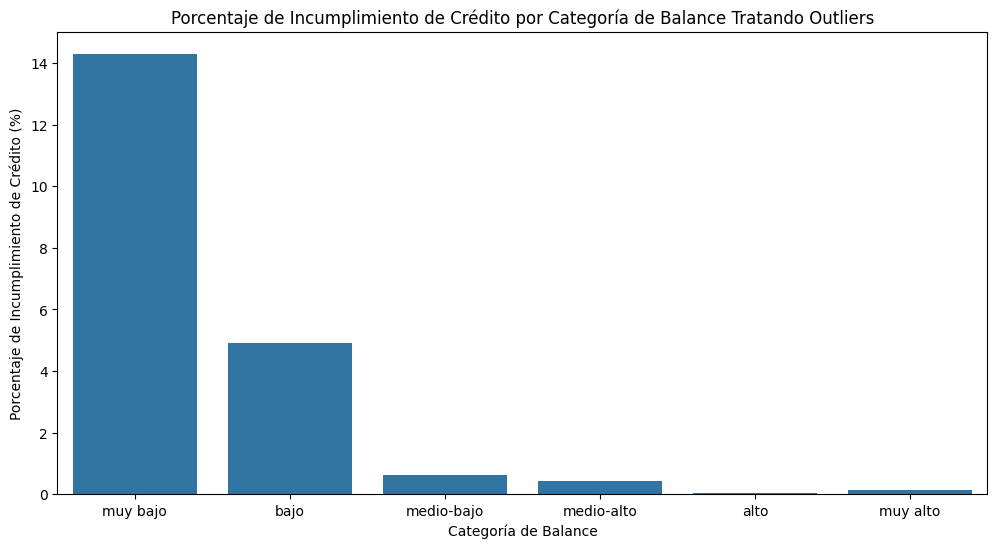

In [48]:
# volvemos a convertir los valores de incumplimiento a numéricos para calcular el % 
df_vistaf['incumplimiento_crédito_num'] = df_vistaf['incumplimiento_crédito'].map({'si': 1, 'no': 0})
incumplimiento_categoria = df_vistaf.groupby('descripcion_balance_log')['incumplimiento_crédito_num'].mean() * 100
# Convertimos a un DataFrame para facilitar la visualización
incumplimiento_categoria = incumplimiento_categoria.reset_index()

order = ['muy bajo', 'bajo', 'medio-bajo', 'medio-alto', 'alto', 'muy alto']
plt.figure(figsize=(12, 6))
sns.barplot(data=incumplimiento_categoria, x='descripcion_balance_log', y='incumplimiento_crédito_num', order = order)
plt.title('Porcentaje de Incumplimiento de Crédito por Categoría de Balance Tratando Outliers')
plt.xlabel('Categoría de Balance')
plt.ylabel('Porcentaje de Incumplimiento de Crédito (%)')
plt.show


REALIZO LA MISMA VISUALIZACIÓN PERO CON UNA CATEGORIZACION SIN PONDERAR (CREADA AUTOMATICAMENTE POR RANGOS DE BALANCE) CON MAYOR NÚMERO DE BINS Y EN FORMA DE GRAFICO DE LINEAS.

1. CON BALANCE_LOG

C:\Users\ueret\AppData\Local\Temp\ipykernel_12624\3928786771.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incumplimiento_por_bin = df_vistaf.groupby('balance_bins')['incumplimiento_crédito_num'].mean() * 100
C:\Users\ueret\AppData\Local\Temp\ipykernel_12624\3928786771.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=incumplimiento_por_bin, x='balance_bins', y='incumplimiento_crédito_num', ci=None)
C:\Users\ueret\AppData\Local\Temp\ipykernel_12624\3928786771.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{interval.left:.1f} - {interval.right:.1f}' for interval in incumplimiento_por_bin['balance_bins']])


[Text(0, 0, '-0.0 - 1.1'),
 Text(1, 0, '1.1 - 2.3'),
 Text(2, 0, '2.3 - 3.4'),
 Text(3, 0, '3.4 - 4.6'),
 Text(4, 0, '4.6 - 5.7'),
 Text(5, 0, '5.7 - 6.8'),
 Text(6, 0, '6.8 - 8.0'),
 Text(7, 0, '8.0 - 9.1'),
 Text(8, 0, '9.1 - 10.2'),
 Text(9, 0, '10.2 - 11.4')]

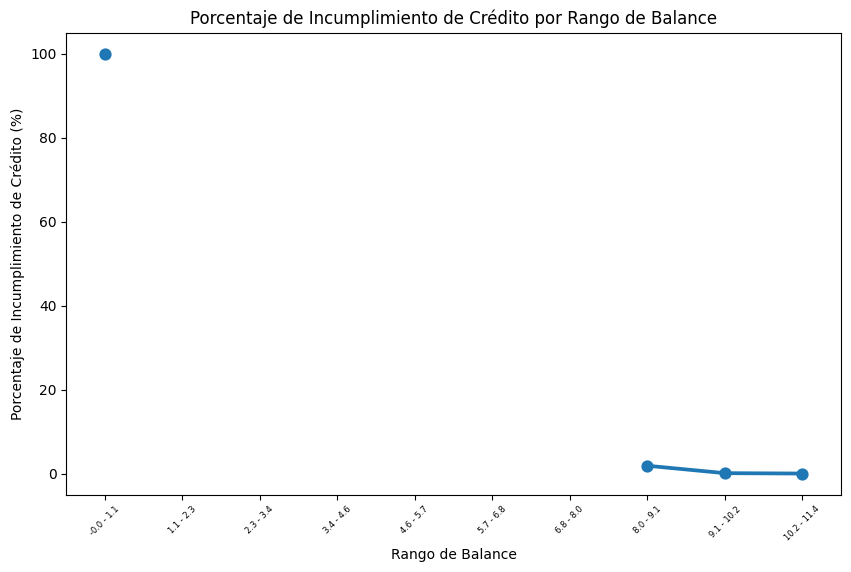

In [24]:
# Crear bins para el balance (agrupando los valores en categorías)
df_vistaf['balance_bins'] = pd.cut(df_vistaf['balance_log'], bins=10)  
# Calcular el porcentaje de incumplimiento por cada bin de balance
incumplimiento_por_bin = df_vistaf.groupby('balance_bins')['incumplimiento_crédito_num'].mean() * 100
# Convertir el resultado a DataFrame para facilitar la visualización
incumplimiento_por_bin = incumplimiento_por_bin.reset_index()


plt.figure(figsize=(10, 6))
sns.pointplot(data=incumplimiento_por_bin, x='balance_bins', y='incumplimiento_crédito_num', ci=None)

plt.title('Porcentaje de Incumplimiento de Crédito por Rango de Balance')
plt.xlabel('Rango de Balance')
plt.ylabel('Porcentaje de Incumplimiento de Crédito (%)')
plt.xticks(rotation=45, fontsize=6)
plt.gca().set_xticklabels([f'{interval.left:.1f} - {interval.right:.1f}' for interval in incumplimiento_por_bin['balance_bins']])


In [25]:
2. CON BALANCE

SyntaxError: invalid syntax (203145458.py, line 1)

C:\Users\ueret\AppData\Local\Temp\ipykernel_12624\1229119796.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incumplimiento_por_bin = df_vistaf.groupby('balance_bins')['incumplimiento_crédito_num'].mean() * 100
C:\Users\ueret\AppData\Local\Temp\ipykernel_12624\1229119796.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=incumplimiento_por_bin, x='balance_bins', y='incumplimiento_crédito_num', ci=None)
C:\Users\ueret\AppData\Local\Temp\ipykernel_12624\1229119796.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{interval.left:.1f} - {interval.right:.1f}' for interval in incumplimiento_por_bin['balance_bins']])


[Text(0, 0, '-6935.1 - 1958.1'),
 Text(1, 0, '1958.1 - 10763.2'),
 Text(2, 0, '10763.2 - 19568.3'),
 Text(3, 0, '19568.3 - 28373.4'),
 Text(4, 0, '28373.4 - 37178.5'),
 Text(5, 0, '37178.5 - 45983.6'),
 Text(6, 0, '45983.6 - 54788.7'),
 Text(7, 0, '54788.7 - 63593.8'),
 Text(8, 0, '63593.8 - 72398.9'),
 Text(9, 0, '72398.9 - 81204.0')]

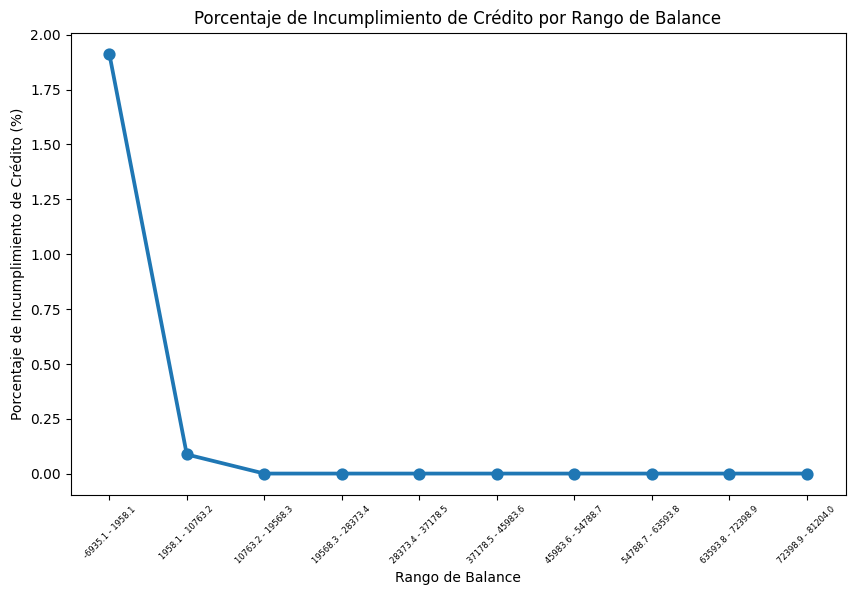

In [26]:
# Crear bins para el balance (agrupando los valores en categorías)
df_vistaf['balance_bins'] = pd.cut(df_vistaf['balance'], bins=10)  
# Calcular el porcentaje de incumplimiento por cada bin de balance
incumplimiento_por_bin = df_vistaf.groupby('balance_bins')['incumplimiento_crédito_num'].mean() * 100
# Convertir el resultado a DataFrame para facilitar la visualización
incumplimiento_por_bin = incumplimiento_por_bin.reset_index()


plt.figure(figsize=(10, 6))
sns.pointplot(data=incumplimiento_por_bin, x='balance_bins', y='incumplimiento_crédito_num', ci=None)

plt.title('Porcentaje de Incumplimiento de Crédito por Rango de Balance')
plt.xlabel('Rango de Balance')
plt.ylabel('Porcentaje de Incumplimiento de Crédito (%)')
plt.xticks(rotation=45, fontsize=6)
plt.gca().set_xticklabels([f'{interval.left:.1f} - {interval.right:.1f}' for interval in incumplimiento_por_bin['balance_bins']])


### LA RELACIÓN ENTRE LAS DOS VARIABLES ES MUY CLARA. HAY UNA RELACIÓN INVERSA ENTRE EL BALANCE Y LA TASA DE INCUMPLIMIENTO DE CRÉDITO.
Cuanto menor es el balance mucho mayor es la tasa de incumplimiento de crédito.

#### Comparando los resultados con y sin tratamiento de outliers, demostramos que la mejor estratégia es no realizar un tratamiento específico de los mismos sinó incluirlos en las categorias posteriores y anteriores. Establecemos entonces 4 categorias de balance.

In [49]:
def cuartiles(df):
    #calcular cuartiles
    Q1 = df.quantile(0.25)
    Q2 = df.quantile(0.50)
    Q3 = df.quantile(0.75)

    #calcular IQR (rango intercuartílico)
    IQR = Q3 - Q1

    #calcular límite outliers
    min_Q = Q1 - 1.5*IQR
    max_Q = Q3 + 1.5*IQR
    
    return Q1, Q2, Q3, min_Q, max_Q

Q1, Q2, Q3, min_Q, max_Q = cuartiles(df_vistaf['balance'])

In [ ]:
def clasificacion_clientes (balance):

    if balance < Q1:
        return 'bajo'
    elif balance < Q2:
        return 'medio-bajo'
    elif balance < Q3:
        return 'medio-alto'
    else:
        return 'alto'
    
df_vistaf['descripcion_balance'] = df_vistaf['balance'].apply(clasificacion_clientes)

df_vistaf.head()

,id,age,job,marital,education,incumplimiento_crédito,balance,housing,loan,balance_log,descripcion_balance,incumplimiento_crédito_num,balance_bins,descripcion_balance_log
0,1,59,admin.,married,secondary,no,2343,1,0,9.125980,alto,0,"(9.109, 10.247]",alto
1,3,56,admin.,married,secondary,no,45,0,0,8.838262,bajo,0,"(7.97, 9.109]",bajo
2,4,41,technician,married,secondary,no,1270,1,0,9.001839,medio-alto,0,"(7.97, 9.109]",medio-alto
3,5,55,services,married,secondary,no,2476,1,0,9.140347,alto,0,"(9.109, 10.247]",alto
4,6,54,admin.,married,tertiary,no,184,0,0,8.858226,medio-bajo,0,"(7.97, 9.109]",medio-bajo


# 4. CUANTIFICAR LA RELACIÓN ENTRE BALANCE E INCUMPLIMIENTO
Ahora que hemos demopstrado la relación inversa entre las dos variables vamos a cuantificarlas y objetivarlas. 

### ODDS RATIO
Comparativa de las possibilidades de incumplimiento entre las diferentes categorias de balance.

In [68]:

# Crear df's de les categorias de balance
saldo_bajo = df_vistaf[df_vistaf['descripcion_balance'] == 'bajo']
saldo_medio_bajo = df_vistaf[df_vistaf['descripcion_balance'] == 'medio-bajo']
saldo_medio_alto = df_vistaf[df_vistaf['descripcion_balance'] == 'medio-alto']
saldo_alto = df_vistaf[df_vistaf['descripcion_balance'] == 'alto']

# Calcular odds para cada categoria
odds_bajo = saldo_bajo['incumplimiento_crédito_num'].mean() / (1 - saldo_bajo['incumplimiento_crédito_num'].mean())
odds_medio_bajo = saldo_medio_bajo['incumplimiento_crédito_num'].mean() / (1 - saldo_medio_bajo['incumplimiento_crédito_num'].mean())
odds_medio_alto = saldo_medio_alto['incumplimiento_crédito_num'].mean() / (1 - saldo_medio_alto['incumplimiento_crédito_num'].mean())
odds_alto = saldo_alto['incumplimiento_crédito_num'].mean() / (1 - saldo_alto['incumplimiento_crédito_num'].mean())

print(f'Odds para saldo bajo: {odds_bajo}')
print(f'Odds para saldo medio-bajo: {odds_medio_bajo}')
print(f'Odds para saldo medio-alto: {odds_medio_alto}')
print(f'Odds para saldo alto: {odds_alto}')

odds_ratio_bajo_medio_bajo = odds_bajo / odds_medio_bajo
odds_ratio_medio_bajo_medio_alto = odds_medio_bajo / odds_medio_alto
odds_ratio_medio_alto_alto = odds_medio_alto / odds_alto


print(f'Odds ratio entre saldo bajo y saldo medio-bajo: {odds_ratio_bajo_medio_bajo}')
print(f'Odds ratio entre saldo medio-bajo y saldo medio-alto: {odds_ratio_medio_bajo_medio_alto}')
print(f'Odds ratio entre saldo medio-alto y saldo alto: {odds_ratio_medio_alto_alto}')


Odds para saldo bajo: 0.051776266061980346
Odds para saldo medio-bajo: 0.006121714079942384
Odds para saldo medio-alto: 0.004314994606256742
Odds para saldo alto: 0.0007168458781362007
Odds ratio entre saldo bajo y saldo medio-bajo: 8.457805344359967
Odds ratio entre saldo medio-bajo y saldo medio-alto: 1.4187072380266477
Odds ratio entre saldo medio-alto y saldo alto: 6.019417475728154


Esto significa que la probabilidad de incumplimiento es 8.45 veces mayor entre los clientes de saldo bajo, respecto a los de medio-bajo.
La de los de medio-bajo serà 1.41 veces mayor que la de los de medio-alto
La de los de saldo medio-alto será 6.01 veces mayor que la de los de saldo alto.

Esto significa que la probabilidad de impago augmenta mucho más en la comparación de las categorias bajo a medio-bajo seguida de la de la de medio-alto a alto.

En la parte media del saldo no hay tanta variación como en los extremos.

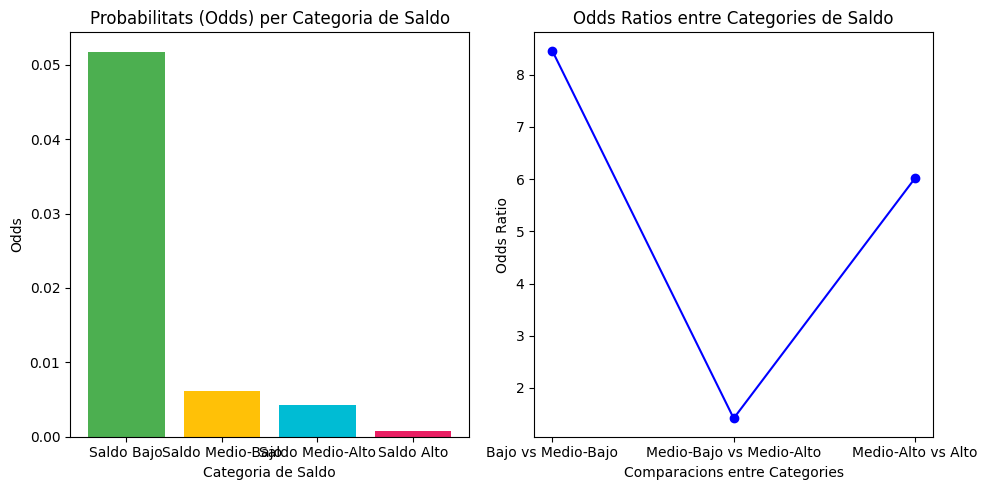

In [1]:
import matplotlib.pyplot as plt

# Dades
odds = [0.051776266061980346, 0.006121714079942384, 0.004314994606256742, 0.0007168458781362007]
categories = ['Saldo Bajo', 'Saldo Medio-Bajo', 'Saldo Medio-Alto', 'Saldo Alto']

odds_ratios = [8.457805344359967, 1.4187072380266477, 6.019417475728154]
comparacions = ['Bajo vs Medio-Bajo', 'Medio-Bajo vs Medio-Alto', 'Medio-Alto vs Alto']

# Gràfic 1: Probabilitats (odds)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(categories, odds, color=['#4CAF50', '#FFC107', '#00BCD4', '#E91E63'])
plt.title('Probabilitats (Odds) per Categoria de Saldo')
plt.ylabel('Odds')
plt.xlabel('Categoria de Saldo')

# Gràfic 2: Odds Ratios
plt.subplot(1, 2, 2)
plt.plot(comparacions, odds_ratios, marker='o', color='blue')
plt.title('Odds Ratios entre Categories de Saldo')
plt.ylabel('Odds Ratio')
plt.xlabel('Comparacions entre Categories')

plt.tight_layout()
plt.show()


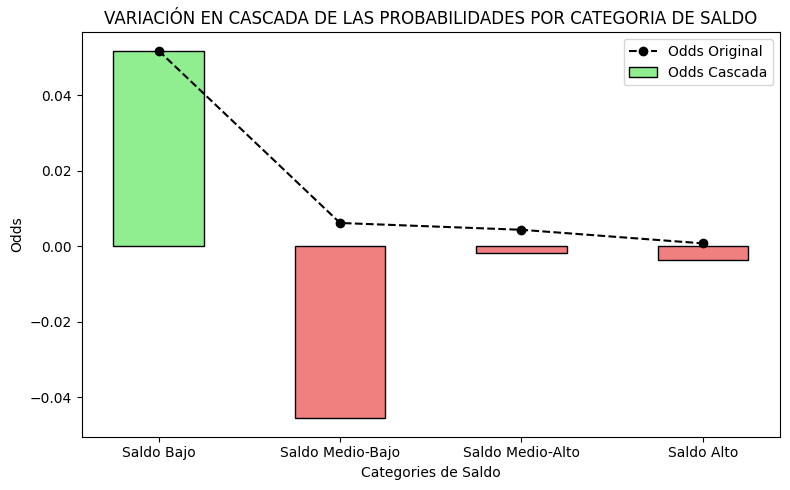

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Dades
odds = [0.051776266061980346, 0.006121714079942384, 0.004314994606256742, 0.0007168458781362007]
categories = ['Saldo Bajo', 'Saldo Medio-Bajo', 'Saldo Medio-Alto', 'Saldo Alto']

# Crear les barres acumulades per a la visualització en cascada
initial_value = odds[0]
cascada = [initial_value]  # Comencem amb el primer valor
for i in range(1, len(odds)):
    cascada.append(odds[i] - odds[i-1])  # Afegim el canvi entre categories

# Definir els colors per a la cascada (més suaus)
colors = ['lightgreen' if change > 0 else 'lightcoral' for change in cascada]

# Crear el gràfic en cascada
fig, ax = plt.subplots(figsize=(8, 5))

bar_positions = np.arange(len(categories))

# Gràfic de barres en cascada
ax.bar(bar_positions, cascada, color=colors, edgecolor='black', width=0.5, label='Odds Cascada')

# Línia de referència per mostrar els "odds" originals
ax.plot(bar_positions, odds, color='black', marker='o', label='Odds Original', linestyle='--')

# Etiquetes i títol
ax.set_xlabel('Categories de Saldo')
ax.set_ylabel('Odds')
ax.set_title('VARIACIÓN EN CASCADA DE LAS PROBABILIDADES POR CATEGORIA DE SALDO')

# Etiquetar les categories de saldo a l'eix X
ax.set_xticks(bar_positions)
ax.set_xticklabels(categories)

# Afegir llegenda
ax.legend()

# Mostrar el gràfic
plt.tight_layout()
plt.show()


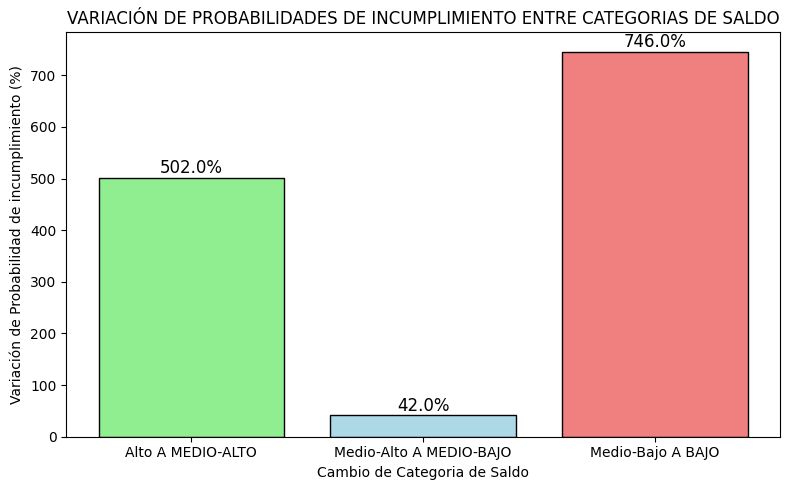

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Dades
categories_cambio = ['Alto A MEDIO-ALTO', 'Medio-Alto A MEDIO-BAJO', 'Medio-Bajo A BAJO']
odds_ratios = [6.02,1.42, 8.46] 

# Calcular el increment de probabilitats en percentatge
increment_percent = [(odds - 1) * 100 for odds in odds_ratios]

# Crear el gràfic de barres
fig, ax = plt.subplots(figsize=(8, 5))

# Gràfic de barres amb els increments percentuals
ax.bar(categories_cambio, increment_percent, color=['lightgreen', 'lightblue', 'lightcoral'], edgecolor='black')

# Afegir etiquetes a sobre de cada barra
for i, value in enumerate(increment_percent):
    ax.text(i, value + 1, f'{round(value, 2)}%', ha='center', va='bottom', fontsize=12)

# Etiquetes i títol
ax.set_xlabel('Cambio de Categoria de Saldo')
ax.set_ylabel('Variación de Probabilidad de incumplimiento (%)')
ax.set_title('VARIACIÓN DE PROBABILIDADES DE INCUMPLIMIENTO ENTRE CATEGORIAS DE SALDO')

# Mostrar el gràfic
plt.tight_layout()
plt.show()


### REGRESION LOGÍSTICA
Obtener una medida de cuanto varia la probabiliad de caer en incumplimiento por cada unidad de más o de menos del saldo (balance). 

In [73]:
df_vistaf = df_vistaf.dropna(subset=['balance', 'incumplimiento_crédito_num'])
print(df_vistaf.head())
print(df_vistaf.columns)

   id  age         job  marital  education incumplimiento_crédito  balance  \
0   1   59      admin.  married  secondary                     no     2343   
1   3   56      admin.  married  secondary                     no       45   
2   4   41  technician  married  secondary                     no     1270   
3   5   55    services  married  secondary                     no     2476   
4   6   54      admin.  married   tertiary                     no      184   

   housing  loan  balance_log descripcion_balance  incumplimiento_crédito_num  \
0        1     0     9.125980                alto                           0   
1        0     0     8.838262                bajo                           0   
2        1     0     9.001839          medio-alto                           0   
3        1     0     9.140347                alto                           0   
4        0     0     8.858226          medio-bajo                           0   

      balance_bins descripcion_balance_log  

In [75]:
%pip install statsmodels
%pip install scikit-learn
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Definir la variable dependent (incompliment de crèdit)
X = df_vistaf[['balance']]  # Variables independents, utilitzant la variable numèrica 'balance'
y = df_vistaf['incumplimiento_crédito_num']  # Variable dependent

# Afegir una constant (intercept) al model
X = sm.add_constant(X)

# Dividir les dades en conjunt d'entrenament i conjunt de prova
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ajustar el model de regressió logística
model = sm.Logit(y_train, X_train)
result = model.fit()

# Mostrar el resum de resultats
print(result.summary())

# Predicció
predicciones = result.predict(X_test)


   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ------- -------------------------------- 2.1/11.0 MB 14.7 MB/s eta 0:00:01
   ---------------------- ----------------- 6.3/11.0 MB 16.8 MB/s eta 0:00:01
   ---------------------------------- ----- 9.4/11.0 MB 19.0 MB/s eta 0:00:01
   ------------------------------------ --- 10.0/11.0 MB 12.4 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 10.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Optimization terminated successfully.
         Current function value: 0.065419
         Iterations 11
                               Logit Regression Results                               
Dep. Variable:     incumplimiento_crédito_num   No. Observations:                 7813
Model:                                  Logit   Df Residuals:                     7811
Method:                                   MLE   Df Model:                            1
Date:               

## Podemos concluir que la relación entre ambas variables es significativa aunque no es la única variable que explica el comportamiento de la variable incumplimiento. Por cada unidad de balance de más la probabilidad de caer en incumplimiento decrece un -0.19%

Explicació del codi:
Variable independent: En lloc de les variables categòriques, ara utilitzem balance, que és numèrica, com a variable independent.
Afegir una constant: Per tenir en compte el terme de la intersecció en la regressió logística.
Dividir les dades: Utilitzem train_test_split per dividir les dades en un conjunt d'entrenament (70%) i un conjunt de prova (30%).
Crear el model: Utilitzem la funció Logit de statsmodels per crear el model de regressió logística.
Ajustar el model: Ajustem el model amb les dades d'entrenament.
Resultats: El resum del model mostrarà els coeficients i altres estadístiques importants.
Interpretació dels resultats:
Coeficient de balance: El coeficient de la variable balance et dirà com afecta el saldo (en termes numèrics) a la probabilitat d'incomplir. Si el coeficient és positiu, un augment en el saldo incrementa la probabilitat d'incomplir el crèdit; si és negatiu, un augment en el saldo redueix aquesta probabilitat.
Valor p (P>|z|): Com en els models anteriors, et mostrarà si el coeficient de balance és estadísticament significatiu (valor p petit, per exemple, inferior a 0.05).
Outliers i prediccions: Després de fer la regressió, també pots fer prediccions sobre el conjunt de prova per veure la capacitat del model per classificar els casos correctament.
Possibles resultats:
Si el coeficient de balance és positiu, pot indicar que els clients amb saldos més alts tenen més probabilitats d'incomplir, el que pot ser contraintuitiu. En canvi, si és negatiu, indicaria que els clients amb saldos més alts tenen menys probabilitats d'incomplir el crèdit.
Els resultats també dependran de l'escala de la variable balance. Si és molt gran, pot ser útil normalitzar-la o escalar-la per millorar la interpretació dels coeficients.
Amb aquesta regressió logística, podràs veure fins a quin punt el saldo influència en la probabilitat d'incomplir el crèdit.


Els resultats de la regressió logística que has obtingut proporcionen informació important sobre la relació entre la variable independent balance i la dependent incumplimiento_crédito_num. Anem a interpretar els resultats pas a pas.

1. Coeficient de la Constant (const):
Coeficient: -3.5110
Interpretació: Aquest coeficient correspon a l'intercepte del model, és a dir, el valor de la probabilitat d'incompliment de crèdit quan el saldo (balance) és zero. El valor negatiu indica que quan el saldo és zero, la probabilitat de no incomplir (0 en incumplimiento_crédito_num) és alta.
2. Coeficient de balance:
Coeficient: -0.0019
Interpretació: Aquest coeficient indica la relació entre la variable balance i la probabilitat de incompliment de crèdit.
Significat: Per cada unitat que augmenti el balance, la probabilitat d'incomplir el crèdit disminueix en aproximadament 0.0019, mantenint constant la resta de les variables. En altres paraules, a mesura que el saldo augmenta, la probabilitat d'incompliment de crèdit disminueix.
Tipus de relació: Negativa (ja que el coeficient és negatiu).
3. Estadístiques de significància:
z: -9.316
P>|z|: 0.000
Interpretació: La P-valor associada a la variable balance és molt petita (molt menor que 0.05), el que indica que el coeficient de balance és estadísticament significatiu. Això vol dir que la variable balance té un impacte important en la probabilitat d'incompliment de crèdit.
4. Interval de confiança:
Interval de confiança (95%): [-0.002, -0.002]
Interpretació: El coeficient de balance té un interval de confiança que no inclou zero, confirmant que és estadísticament significatiu.
5. Pseudo R-squared: 0.1287
Interpretació: Aquest valor ens indica que el model explica aproximadament el 12.87% de la variabilitat de la variable dependent (incumplimiento_crédito_num). En regressions logístiques, el pseudo R-squared no és tan alt com en una regressió lineal, però un valor de 0.12 pot ser acceptable depenent de la naturalesa del problema.
6. Log-Likelihood: -511.12
Interpretació: Aquesta és la funció de log-versemblança per al model ajustat. El valor negatiu indica que el model no és perfecte, però s'ha ajustat a les dades de forma coherent.
7. Advertència de quasi-separació completa:
Missatge: "Possibly complete quasi-separation: A fraction 0.15 of observations can be perfectly predicted."
Interpretació: Aquest missatge vol dir que una part de les observacions (aproximadament el 15%) poden ser predites perfectament pel model, això pot indicar que hi ha certa separació quasi-completa entre les dues categories de la variable dependent (incumplimiento_crédito_num). Això pot comportar problemes d'identificació en el model, ja que algunes variables podrien tenir un impacte tan fort que es poden predir perfectament algunes de les observacions. Aquesta situació pot afectar la validesa del model i les seves conclusions.
Conclusió:
Rellevància de la variable balance: El saldo (balance) és significatiu per predir la probabilitat d'incompliment de crèdit, i té una relació negativa amb la probabilitat d'incompliment: com més alt sigui el saldo, més baixa és la probabilitat d'incomplir el crèdit.
Precaucions: La separació quasi-completa de les dades pot indicar que el model no s'ajusta perfectament a totes les observacions. Potser caldria considerar regularització o revisar si hi ha altres variables que també influencien l'incompliment.
Si tens més preguntes o vols aprofundir més en el model, no dubtis a dir-m'ho!

In [53]:
df_vistaf.to_csv('C:\\Users\\ueret\\OneDrive\\Escritorio\\SIMULADOR\\sprintamitges.csv', index=False)